In [96]:
import pandas as pd
import json
from collections import defaultdict
from config import TEST_ROOT, TRAIN_ROOT
import os 

In [180]:
# словарь для выдуманных меток и их соответствий реальным
lable_mapping_1 = {
    'Philosophy': 'Humanities',
    'Economics': 'Social Sciences',
    'Economics and Business': 'Social Sciences',
    'Economics and Finance': 'Social Sciences',
    'Business and Management': 'Social Sciences',
    'Law': 'Social Sciences',
    'Law and Legal Studies': 'Social Sciences',
    'Finance': 'Social Sciences',
    'Education and Pedagogy': 'Social Sciences',
    'Education': 'Social Sciences',
    'Urban Planning': 'Social Sciences',
    'Legal and Jurisprudence': 'Social Sciences',
    'Law and Jurisprudence': 'Social Sciences',
}

lable_mapping_2 = {}

In [181]:
TEST_ROOT = 'data/test/'
TRAIN_ROOT = 'data/train/'


def label_determination(predictions, oecd_labels, lable_mapping):
    '''Функция для выбора метки на основании нескольких предсказаний.'''
    label = None
    labels_counter = defaultdict(int)

    for pred in predictions:
        labels_counter[pred['class']] += 1

    # список меток и их количества (label, count), отсортированный по убыванию     
    sorted_labels = sorted(labels_counter.items(), key=lambda x: x[1], reverse=True)

    if sorted_labels[0][1] >= 2 and sorted_labels[0][0] in oecd_labels:
        label = sorted_labels[0][0]
    elif sorted_labels[0][1] >= 2 and sorted_labels[0][0] in lable_mapping.keys():
        mapped_label = lable_mapping[sorted_labels[0][0]]
        if mapped_label in oecd_labels:
            label = mapped_label

    return label, sorted_labels



def prediction_to_df(file_name, test=True, group=False):
    '''Функция для преобразования файла с предсказаниями в DataFrame.'''
    if group:
        with open(f'data/zeroshot_topics_2.json', "r") as f:
            lable_mapping = lable_mapping_2
            oecd_labels = list(json.load(f)[file_name[-1]].values())
    else:
        with open(f'data/zeroshot_topics_1.json', "r") as f:
            lable_mapping = lable_mapping_1
            oecd_labels = list(json.load(f).values())

    data_root = TEST_ROOT if test else TRAIN_ROOT
    file_path = os.path.join(data_root, f'pred_{file_name}.jsonl')

    with open(file_path, 'r') as f:
        articles = []
        for line in f:
            article = json.loads(line)
            if len(article['predicted_classes']) < 3 and article['predicted_classes'][0]['class'] in oecd_labels:
                if group:
                    article['OECD_pred'] =  article['predicted_classes'][0]['class']
                else:
                    article['first_OECD_pred'] =  article['predicted_classes'][0]['class']
            else:
                if group:
                    article['OECD_pred'], article['sorted_preds'] =  label_determination(article['predicted_classes'], oecd_labels, lable_mapping)
                else:
                    article['first_OECD_pred'], article['first_sorted_preds'] =  label_determination(article['predicted_classes'], oecd_labels, lable_mapping)
            articles.append(article)

    df_pred = pd.DataFrame(articles)
    df_pred = df_pred.rename(columns={"ID": "eLIBRARY ID"})

    return df_pred

In [176]:
# первичное предсказание
df_pred_first = prediction_to_df('test', test=True, group=False)
df_pred_first[df_pred_first['first_OECD_pred'].isna()] # доработать руками темы!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! но пока дроп

# Далее 6 шагов дозаполнения
for i in range(6):
    df_pred_second = prediction_to_df(f"{i}", test=True, group=True)
    #df_pred[df_pred['OECD_pred'].isna()] # доработать руками темы!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! но пока дроп
    df_pred_second.drop(columns=['predicted_classes'], inplace=True)
    # merge временно, но колонки обновим вручную
    df_pred_first = df_pred_first.merge(df_pred_second, on="eLIBRARY ID", how="left", suffixes=("", f"_{i}"))

for i in range(1, 6):
    df_pred_first["sorted_preds"] = df_pred_first["sorted_preds"].fillna(df_pred_first[f"sorted_preds_{i}"])
    df_pred_first["OECD_pred"]   = df_pred_first["OECD_pred"].fillna(df_pred_first[f"OECD_pred_{i}"])
    # удаляем временные колонки
    df_pred_first.drop(columns=[f"sorted_preds_{i}", f"OECD_pred_{i}"], inplace=True)

#df_pred = df_pred_first[['eLIBRARY ID', 'first_OECD_pred', 'OECD_pred']]
df_pred_first[df_pred_first['OECD_pred'].isna()]['sorted_preds'].to_list()


[[('Economics and business', 1),
  ('Sports', 1),
  ('Sports and physical activity', 1)],
 [('Industrial engineering', 2), ('Other engineering and technologies', 1)],
 [('None', 2)],
 [('Digital technologies in healthcare', 1),
  ('Digital Technologies in Healthcare', 1),
  ('Health sciences', 1)],
 [('Philosophy', 1),
  ('History and archaeology', 1),
  ('Philosophy, ethics and religion', 1)],
 [('Civil engineering', 1),
  ('Materials engineering', 1),
  ('Industrial biotechnology', 1)],
 [('Mining and metallurgical engineering', 1),
  ('Civil engineering', 1),
  ('Mining and metallurgy', 1)],
 [('None', 2)],
 [('None', 2), ('Other medical sciences', 1)],
 [('None', 2), ('Other engineering and technologies', 1)],
 [('Environmental sciences', 2)],
 [('Physical sciences and astronomy', 1),
  ('None', 1),
  ('Economic sciences', 1)],
 [('None', 2), ('Other natural sciences', 1)],
 [('Religion', 2), ('Sociology', 1)],
 [('None', 2), ('Other engineering and technologies', 1)],
 [('None', 2

In [182]:
# первичное предсказание
df_pred_first = prediction_to_df('extra_test', test=True, group=False)
df_pred_first[df_pred_first['first_OECD_pred'].isna()] 

,eLIBRARY ID,predicted_classes,first_OECD_pred,first_sorted_preds
28,80242466,"[{'step': 1, 'class': 'Business and Economics'...",None,"[(Business and Economics, 2)]"
118,75201985,"[{'step': 1, 'class': 'Social Sciences'}, {'st...",None,"[(Social Sciences, 1), (Engineering and Techno..."
167,74485659,"[{'step': 1, 'class': 'Engineering and Technol...",None,"[(Engineering and Technology, 1), (Sports and ..."
175,67249699,"[{'step': 1, 'class': 'Natural Sciences'}, {'s...",None,"[(Natural Sciences, 1), (Physical Education, 1..."
185,65587082,"[{'step': 1, 'class': 'Natural Sciences'}, {'s...",None,"[(Psychological Sciences, 2), (Natural Science..."
217,72910991,"[{'step': 1, 'class': 'Media and Communication...",None,"[(Media and Communication, 1), (Social Science..."
290,68946775,"[{'step': 1, 'class': 'Natural Sciences'}, {'s...",None,"[(Natural Sciences, 1), (Economics and Busines..."
341,65549751,"[{'step': 1, 'class': 'Social Sciences'}, {'st...",None,"[(Social Sciences, 1), (Economics and Finance,..."
351,77544537,"[{'step': 1, 'class': 'Social Sciences'}, {'st...",None,"[(Social Sciences, 1), (Finance, 1), (Economic..."
353,77544551,"[{'step': 1, 'class': 'Engineering and Technol...",None,"[(Engineering and Technology, 1), (Economics, ..."


In [183]:
df_pred_first['first_OECD_pred'].value_counts()

first_OECD_pred
Engineering and Technology     495
Social Sciences                486
Natural Sciences               104
Humanities                      87
Medical and Health Sciences     47
Agricultural Sciences           35
Name: count, dtype: int64

In [178]:
df_pred_first['first_OECD_pred'].value_counts()

first_OECD_pred
Social Sciences                515
Engineering and Technology     496
Natural Sciences                96
Humanities                      87
Medical and Health Sciences     45
Agricultural Sciences           38
Name: count, dtype: int64

In [144]:
df_pred.dropna(subset=['OECD_pred'], inplace=True)
df_main = pd.read_csv('data/final_clean.csv')

df = df_main.merge(df_pred, on="eLIBRARY ID", how="left")
df = df.merge(df_pred_1, on="eLIBRARY ID", how="left")
df = df[['eLIBRARY ID', 'title_en', 'abstract_en', 'key_words_en','OECD', 'first_OECD', 'first_OECD_pred', 'OECD_pred']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4161 entries, 0 to 4160
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   eLIBRARY ID      4161 non-null   int64 
 1   title_en         4161 non-null   object
 2   abstract_en      4161 non-null   object
 3   key_words_en     4161 non-null   object
 4   OECD             4161 non-null   object
 5   first_OECD       4161 non-null   object
 6   first_OECD_pred  1277 non-null   object
 7   OECD_pred        306 non-null    object
dtypes: int64(1), object(7)
memory usage: 260.2+ KB


In [94]:
df.to_csv('data/pred_1.csv', index=False)

In [164]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


df_clean = df[df['OECD_pred'].notna() & (df['OECD_pred'] != "")]

y_true = df_clean.loc[df_clean['first_OECD'] == 'Engineering and Technology', 'OECD']
y_pred = df_clean.loc[df_clean['first_OECD'] == 'Engineering and Technology', 'OECD_pred']

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

# Classification report (precision, recall, f1-score)
print("\nClassification report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:")
print(cm)


Accuracy: 0.40384615384615385

Classification report:
                                                precision    recall  f1-score   support

                             Civil engineering       0.15      0.40      0.22         5
Electrical engineering, electronic engineering       0.60      0.50      0.55        18
                     Environmental engineering       0.57      0.42      0.48        19
                      Industrial biotechnology       0.00      0.00      0.00         1
                         Materials engineering       0.00      0.00      0.00         2
                        Mechanical engineering       0.50      0.25      0.33         4
                               Nano-technology       0.00      0.00      0.00         0
            Other engineering and technologies       0.33      0.33      0.33         3

                                      accuracy                           0.40        52
                                     macro avg       0.27      0

/home/galinyshka/code/articles_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/galinyshka/code/articles_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/galinyshka/code/articles_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

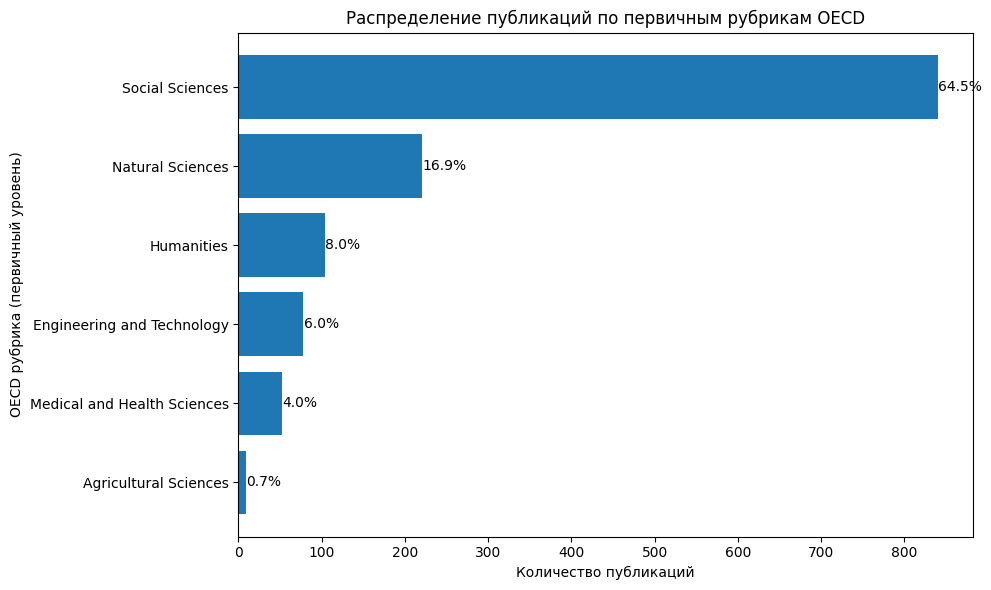

In [159]:
import matplotlib.pyplot as plt
# считаем категории, исключая "нет"
counts = (
    df['first_OECD']
    .value_counts()
    .loc[lambda s: s.index != 'нет']
    .sort_values(ascending=True)
)

total = counts.sum()  # общее количество для процентов

plt.figure(figsize=(10, 6))
bars = plt.barh(counts.index, counts.values)

# добавление процентов
for bar, value in zip(bars, counts.values):
    percent = value / total * 100
    plt.text(
        bar.get_width() + 0.5,   # чуть правее бара
        bar.get_y() + bar.get_height() / 2,
        f"{percent:.1f}%",       # формат: одна цифра после запятой
        va='center'
    )

plt.xlabel("Количество публикаций")
plt.ylabel("OECD рубрика (первичный уровень)")
plt.title("Распределение публикаций по первичным рубрикам OECD")

plt.tight_layout()
plt.show()


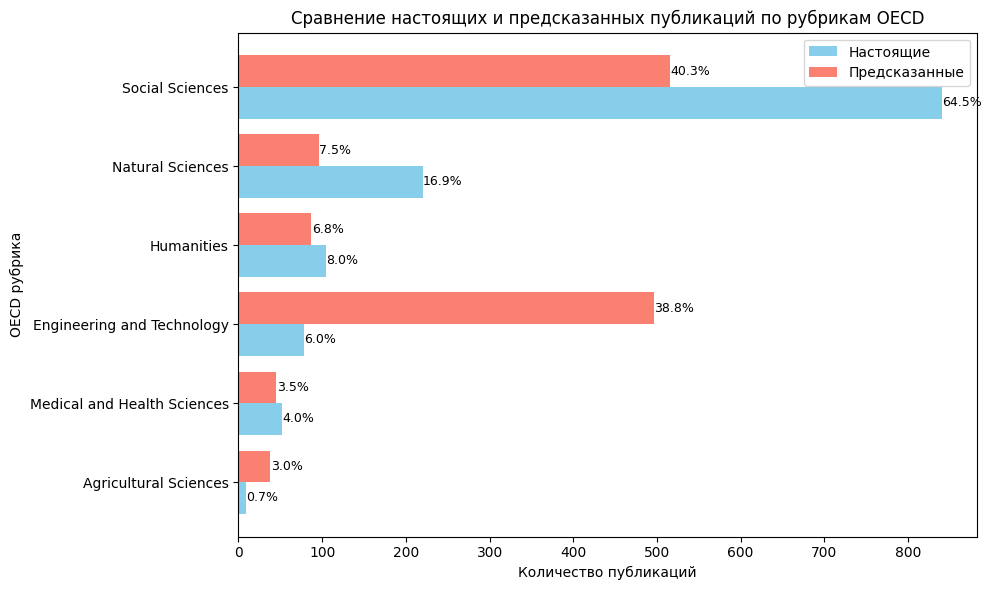

In [161]:
import matplotlib.pyplot as plt
import numpy as np

# фильтруем "нет"
true_counts = df['first_OECD'].value_counts().loc[lambda s: s.index != 'нет'].sort_values(ascending=True)
pred_counts = df['first_OECD_pred'].value_counts().loc[lambda s: s.index != 'нет'].reindex(true_counts.index, fill_value=0)

# позиции для горизонтальных баров
y_pos = np.arange(len(true_counts))
height = 0.4

plt.figure(figsize=(10, 6))

# настоящие публикации
plt.barh(y_pos - height/2, true_counts.values, height=height, color='skyblue', label='Настоящие')

# предсказанные публикации
plt.barh(y_pos + height/2, pred_counts.values, height=height, color='salmon', label='Предсказанные')

# подписи процентов для каждой серии
total_true = true_counts.sum()
total_pred = pred_counts.sum()

for i, (t, p) in enumerate(zip(true_counts.values, pred_counts.values)):
    plt.text(t + 0.5, i - height/2, f"{t/total_true*100:.1f}%", va='center', fontsize=9)
    plt.text(p + 0.5, i + height/2, f"{p/total_pred*100:.1f}%", va='center', fontsize=9)

plt.yticks(y_pos, true_counts.index)
plt.xlabel("Количество публикаций")
plt.ylabel("OECD рубрика")
plt.title("Сравнение настоящих и предсказанных публикаций по рубрикам OECD")
plt.legend()
plt.tight_layout()
plt.show()


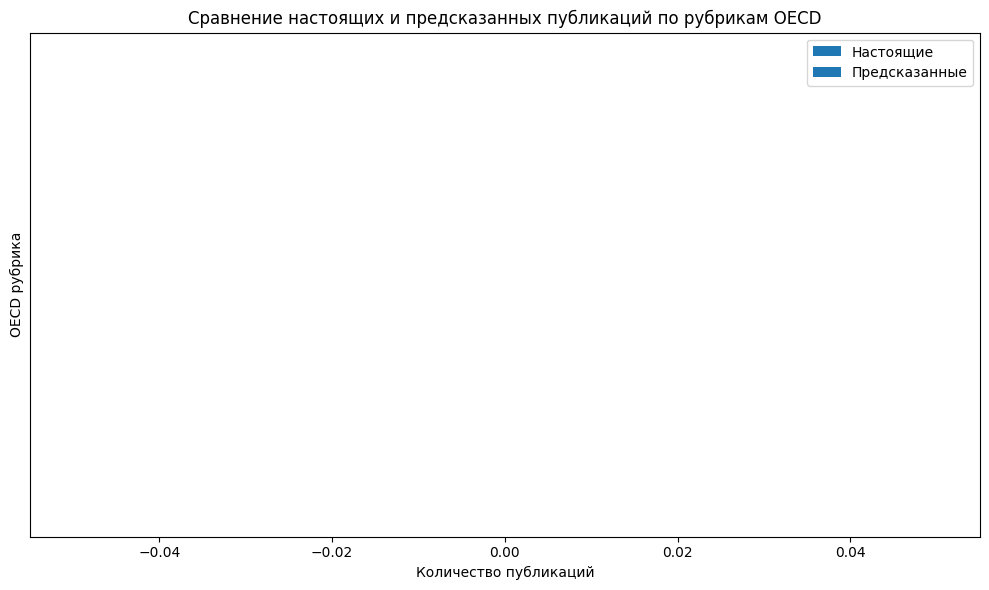

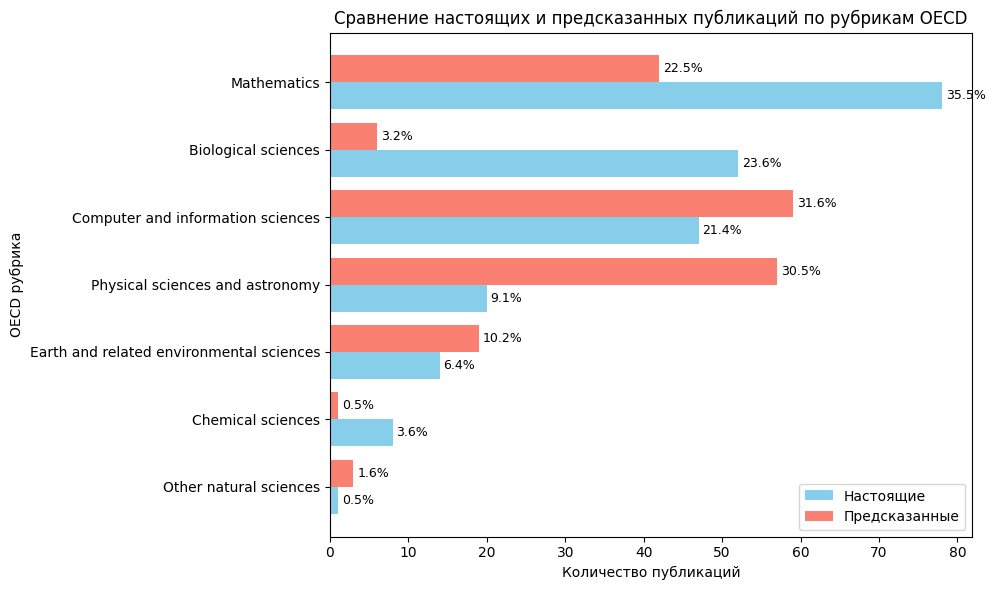

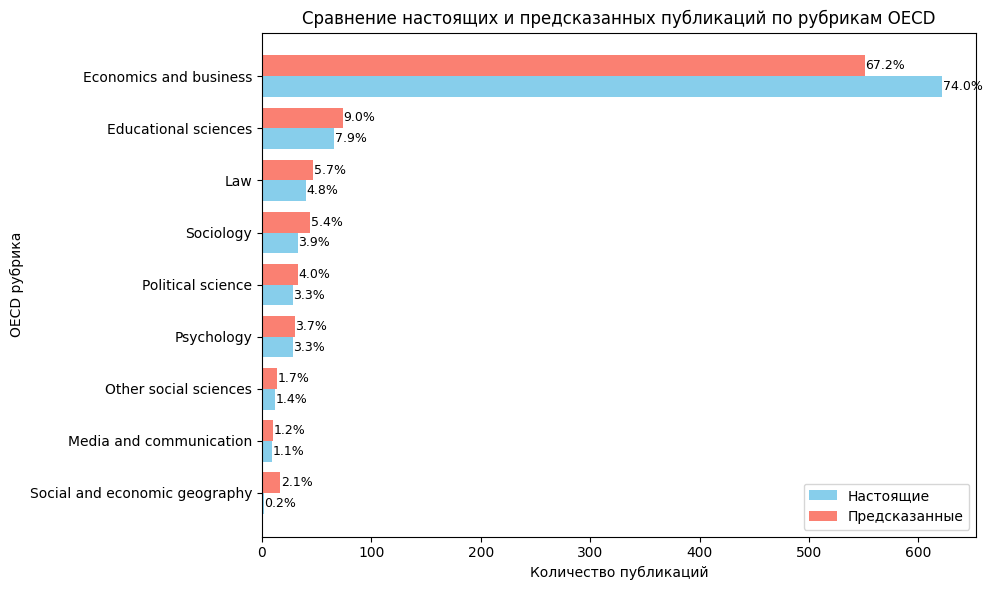

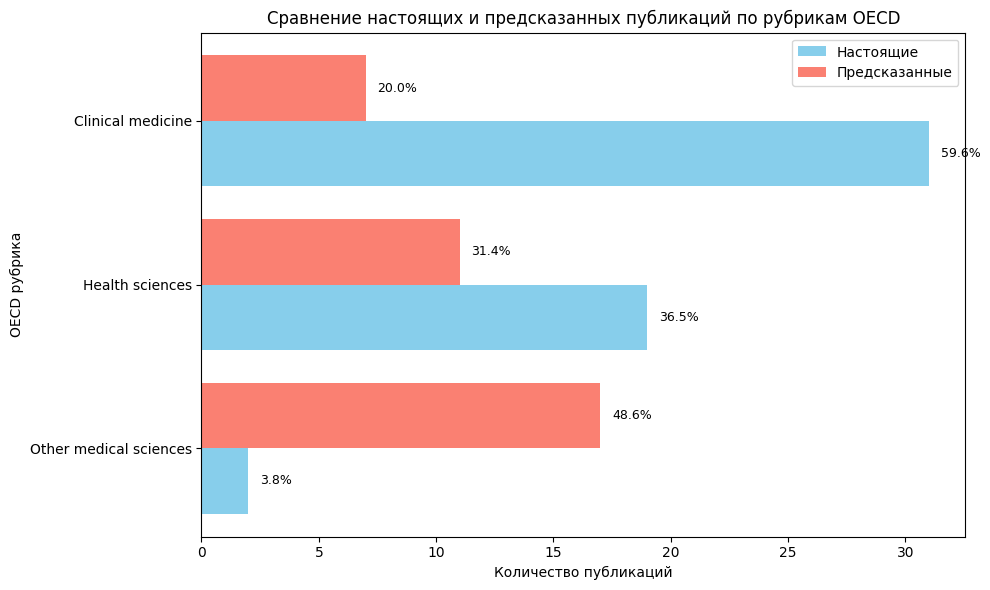

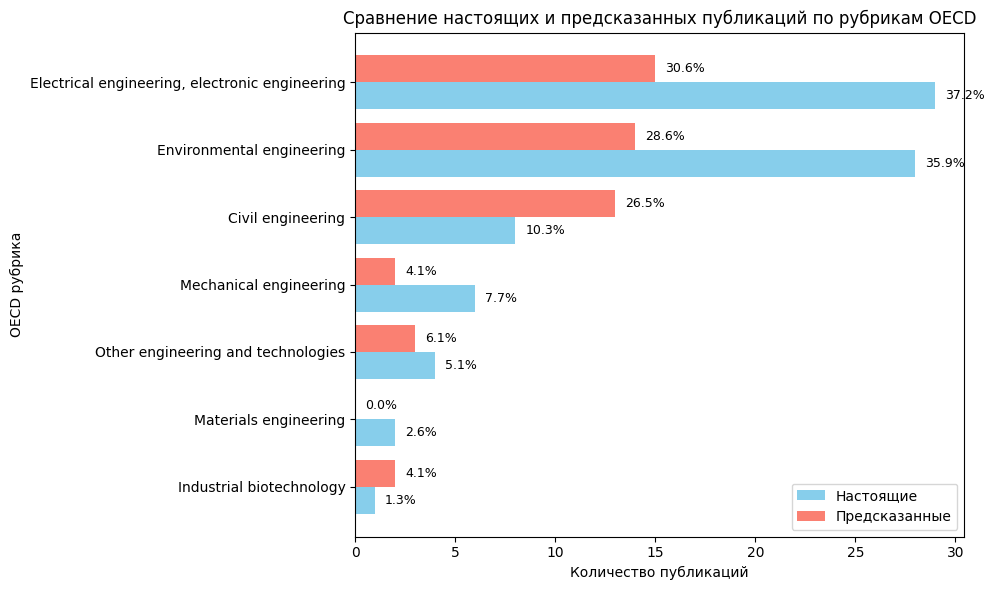

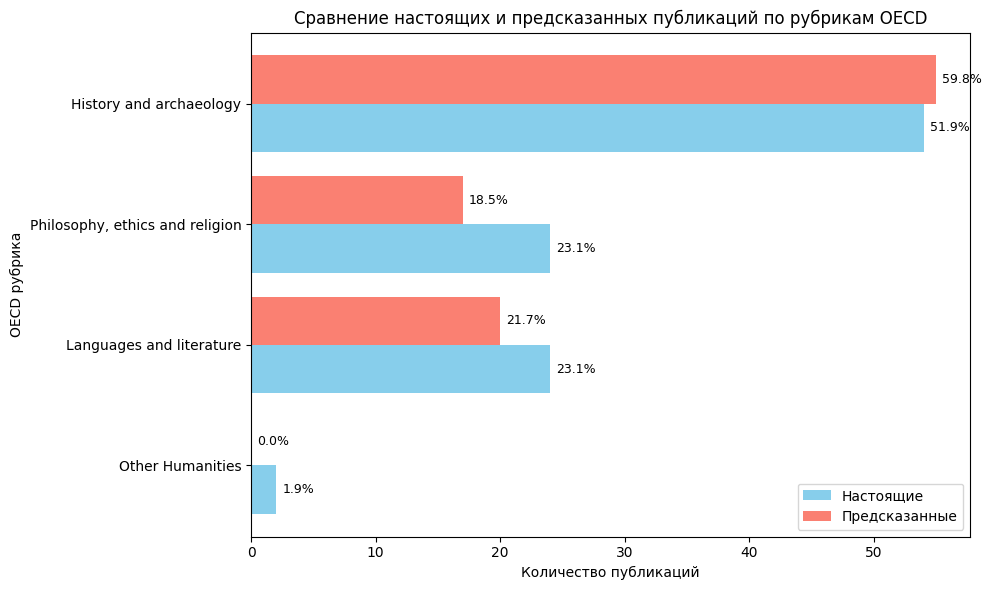

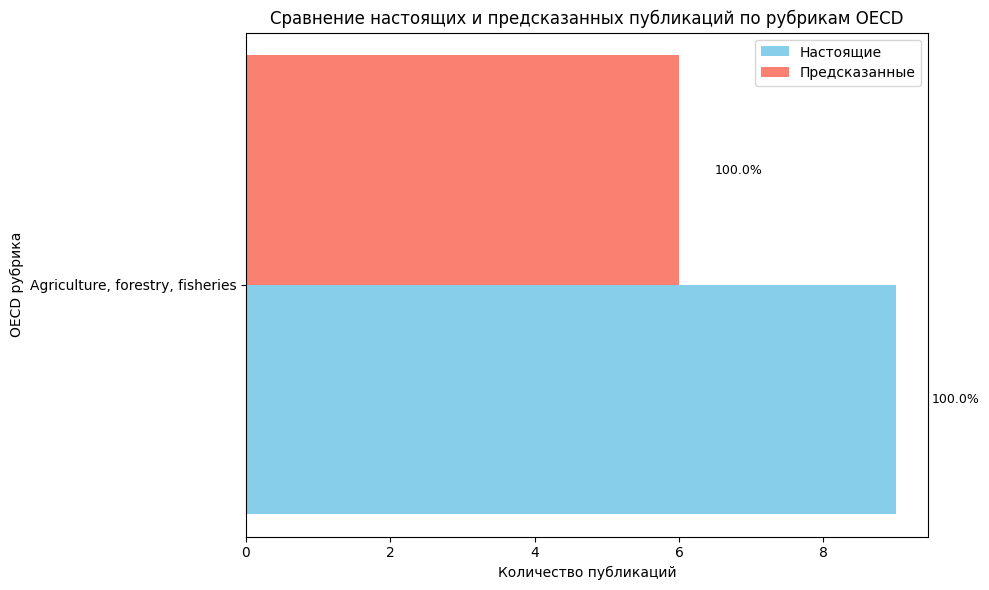

In [163]:
for label in df['first_OECD'].unique():
    # фильтруем "нет"
    df_label = df[df['first_OECD'] == label]
    true_counts = df_label['OECD'].value_counts().loc[lambda s: s.index != 'нет'].sort_values(ascending=True)
    pred_counts = df_label['OECD_pred'].value_counts().loc[lambda s: s.index != 'нет'].reindex(true_counts.index, fill_value=0)

    # позиции для горизонтальных баров
    y_pos = np.arange(len(true_counts))
    height = 0.4

    plt.figure(figsize=(10, 6))

    # настоящие публикации
    plt.barh(y_pos - height/2, true_counts.values, height=height, color='skyblue', label='Настоящие')

    # предсказанные публикации
    plt.barh(y_pos + height/2, pred_counts.values, height=height, color='salmon', label='Предсказанные')

    # подписи процентов для каждой серии
    total_true = true_counts.sum()
    total_pred = pred_counts.sum()

    for i, (t, p) in enumerate(zip(true_counts.values, pred_counts.values)):
        plt.text(t + 0.5, i - height/2, f"{t/total_true*100:.1f}%", va='center', fontsize=9)
        plt.text(p + 0.5, i + height/2, f"{p/total_pred*100:.1f}%", va='center', fontsize=9)

    plt.yticks(y_pos, true_counts.index)
    plt.xlabel("Количество публикаций")
    plt.ylabel("OECD рубрика")
    plt.title("Сравнение настоящих и предсказанных публикаций по рубрикам OECD")
    plt.legend()
    plt.tight_layout()
    plt.show()
